<h1>Bitcoin Price Predict</h1>

Sobre o Projeto: Esse projeto trata-se do desenvolvimento de um modelo preditivo para prever os preços futuros do Bitcoin em um 'range' de 30 dias, começando com a limpeza e pré-processamento de um dataset contendo os preços históricos do Bitcoin por minuto. Também foi desenvolvido uma funcionalidade utilizando regressão linear para prever os valores de alta, baixa e fechamento do bitcoin com base no valor de abertura da moeda. ("alterar caso o dataset mude")

In [47]:
import joblib
import nbformat
import math

import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import plotly.express as px


from datetime import datetime
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle

from matplotlib import pyplot as plt

<h2>Leitura e Tratamento dos dados</h2>

<h4>Lê os arquivos csv que contem os dados</h4>

In [2]:
df_BTC_2017 = pd.read_csv("archive/BTC-2017min.csv")
df_BTC_2018 = pd.read_csv("archive/BTC-2018min.csv")
df_BTC_2019 = pd.read_csv("archive/BTC-2019min.csv")
df_BTC_2020 = pd.read_csv("archive/BTC-2020min.csv")
df_BTC_2021 = pd.read_csv("archive/BTC-2021min.csv")
df_BTC_daily = pd.read_csv("archive/BTC-Daily.csv")

<h4>Concatena os datasets de diferentes anos em um único dataframe</h4>

In [3]:
concat_BTC = pd.concat([df_BTC_2017, df_BTC_2018], axis=0)
concat_BTC = pd.concat([concat_BTC, df_BTC_2019], axis=0)
concat_BTC = pd.concat([concat_BTC, df_BTC_2020], axis=0)
concat_BTC = pd.concat([concat_BTC, df_BTC_2021], axis=0)

<h4>Ordena o dataframe pela coluna 'data'</h4>

In [4]:
concat_BTC["date"] = pd.to_datetime(concat_BTC["date"])
BTC_df = concat_BTC.sort_values(by="date")
BTC_df.drop(columns=["unix", "symbol"], inplace=True)

BTC_df.head()

,date,open,high,low,close,Volume BTC,Volume USD
525598,2017-01-01 00:01:00,966.34,966.34,966.34,966.34,7.610000,7353.847400
525597,2017-01-01 00:02:00,966.16,966.37,966.16,966.37,8.087376,7815.397864
525596,2017-01-01 00:03:00,966.37,966.37,966.37,966.37,0.000000,0.000000
525595,2017-01-01 00:04:00,966.37,966.37,966.37,966.37,0.000000,0.000000
525594,2017-01-01 00:05:00,966.43,966.43,966.43,966.43,0.107000,103.408010


<h2>Limpesa dos dados</h2>

<h4>Verifica a existência de dados nulos ou nan<h4>

In [5]:
BTC_df.isnull().sum()

date          0
open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64

<h4>Informa o tipo dos dados</h4>
O tipo 'object' indicam existência de strings entre os dados, oque se configura como sujeira

In [6]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2675301 entries, 525598 to 0
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   open        float64       
 2   high        float64       
 3   low         float64       
 4   close       float64       
 5   Volume BTC  float64       
 6   Volume USD  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 163.3 MB


<h4>Busca por valores nulos</h4>

In [7]:
print("Null values:", BTC_df.isnull().values.sum())

Null values: 0


In [8]:
print("NaN values:", BTC_df.isnull().values.any())

NaN values: False


In [9]:
#criar as funções que limpam os dados mesmo assim 

<h2>Análise dos dados</h2>

<h4>Faz um copia do dataframe para adicionar as colunas 'hours' e 'minutes'</h4>

In [10]:
BTC_df_date = BTC_df.copy()
BTC_df_date["date"] = pd.to_datetime(BTC_df_date["date"])

BTC_df_date.head()

,date,open,high,low,close,Volume BTC,Volume USD
525598,2017-01-01 00:01:00,966.34,966.34,966.34,966.34,7.610000,7353.847400
525597,2017-01-01 00:02:00,966.16,966.37,966.16,966.37,8.087376,7815.397864
525596,2017-01-01 00:03:00,966.37,966.37,966.37,966.37,0.000000,0.000000
525595,2017-01-01 00:04:00,966.37,966.37,966.37,966.37,0.000000,0.000000
525594,2017-01-01 00:05:00,966.43,966.43,966.43,966.43,0.107000,103.408010


In [11]:

BTC_df_date["hours"] = BTC_df_date["date"].dt.strftime('%H')
BTC_df_date["minutes"] = BTC_df_date["date"].dt.strftime('%M')

new_order = ['date', 'hours', 'minutes', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']
BTC_df_date = BTC_df_date[new_order]

BTC_df_date.head()

,date,hours,minutes,open,high,low,close,Volume BTC,Volume USD
525598,2017-01-01 00:01:00,00,01,966.34,966.34,966.34,966.34,7.610000,7353.847400
525597,2017-01-01 00:02:00,00,02,966.16,966.37,966.16,966.37,8.087376,7815.397864
525596,2017-01-01 00:03:00,00,03,966.37,966.37,966.37,966.37,0.000000,0.000000
525595,2017-01-01 00:04:00,00,04,966.37,966.37,966.37,966.37,0.000000,0.000000
525594,2017-01-01 00:05:00,00,05,966.43,966.43,966.43,966.43,0.107000,103.408010


<h4>Descreve estatisticamente os dados</h4>

In [12]:
cols = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']
BTC_df_date[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
open,2675301.0,16209.934130,17422.284122,752.00,5599.040000,8703.120000,15500.000000,6.900000e+04
high,2675301.0,16219.884786,17432.005397,752.81,5602.000000,8709.860000,15510.000000,6.900000e+04
low,2675301.0,16199.614220,17412.357549,751.34,5594.980000,8696.910000,15487.930000,6.879999e+04
close,2675301.0,16209.956812,17422.441952,752.04,5598.880000,8702.810000,15500.000000,6.900000e+04
Volume BTC,2675301.0,6.130515,16.292996,0.00,0.251895,1.467694,5.507826,1.616060e+03
Volume USD,2675301.0,70794.025116,203035.282225,0.00,2244.546085,14664.666104,58659.083903,1.396792e+07


<h4>Correlação dos dados</h4>

In [13]:
BTC_df_date.corr()

,date,hours,minutes,open,high,low,close,Volume BTC,Volume USD
date,1.000000,0.000490,0.000003,0.779437,0.779404,0.779484,0.779437,-0.124351,0.132140
hours,0.000490,1.000000,0.000017,0.000331,0.000360,0.000295,0.000332,0.035704,0.030170
minutes,0.000003,0.000017,1.000000,-0.000007,-0.000029,0.000014,-0.000008,-0.014853,-0.014346
open,0.779437,0.000331,-0.000007,1.000000,0.999999,0.999999,0.999999,-0.100665,0.193483
high,0.779404,0.000360,-0.000029,0.999999,1.000000,0.999998,0.999999,-0.100439,0.193935
low,0.779484,0.000295,0.000014,0.999999,0.999998,1.000000,0.999999,-0.100938,0.192952
close,0.779437,0.000332,-0.000008,0.999999,0.999999,0.999999,1.000000,-0.100687,0.193455
Volume BTC,-0.124351,0.035704,-0.014853,-0.100665,-0.100439,-0.100938,-0.100687,1.000000,0.652679
Volume USD,0.132140,0.030170,-0.014346,0.193483,0.193935,0.192952,0.193455,0.652679,1.000000


<h4>HeatMap da Correlação</h4>

['date', 'hours', 'minutes', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']


<Axes: >

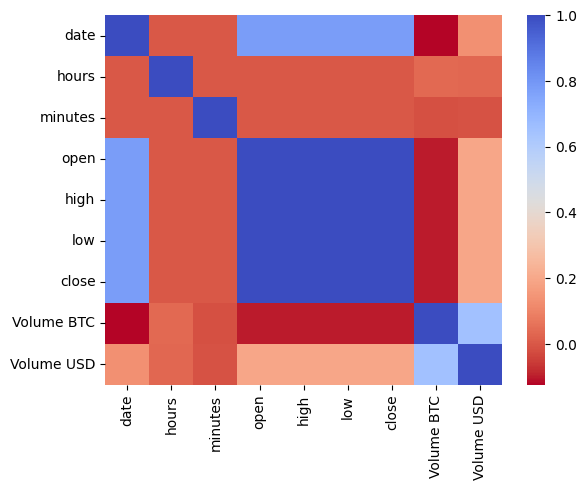

In [14]:
atributos = list(BTC_df_date.columns)
print(atributos)
sns.heatmap(BTC_df_date[atributos[:]].corr(), cmap='coolwarm_r')

<h2>Gráficos da correlação linear para o dataframe: 'df_BTC_daily'</h2>

<h4>Gráfico da reta entre 'open' e 'close'</h4>

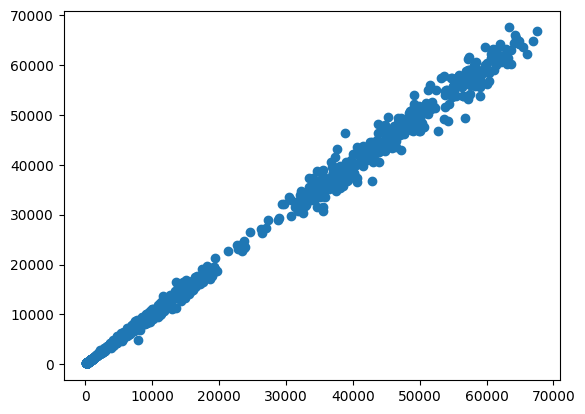

In [15]:

plt.scatter(df_BTC_daily["open"].values, df_BTC_daily["close"].values)

<h4>Gráfico da reta entre 'open' e 'high'</h4>

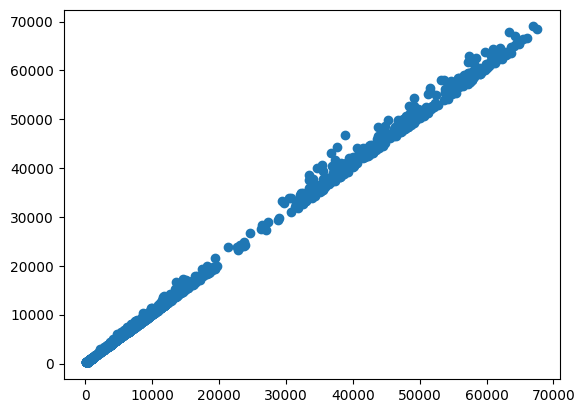

In [16]:
plt.scatter(df_BTC_daily["open"].values, df_BTC_daily["high"].values)

<h4>Gráfico da reta entre 'open' e 'low'</h4>

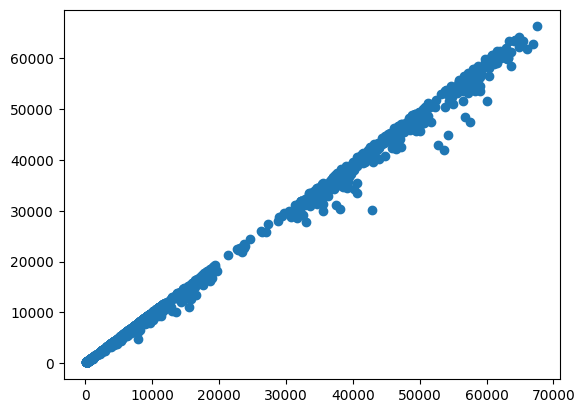

In [17]:
plt.scatter(df_BTC_daily["open"].values, df_BTC_daily["low"].values)

<h2>Criação dos modelos de Regressão Linear</h2>

Modelo de Regressao Linear(high)

In [18]:
x = df_BTC_daily["open"].values.reshape(-1, 1)
y = df_BTC_daily["high"].values

predict_teste_values = [[966.34], [912], [320]]

model_high = linear_model.LinearRegression()
model_high.fit(x, y)


LinearRegression()

In [19]:
joblib.dump(model_high, "models/high_model.pkl")
loaded_model = joblib.load("models/high_model.pkl") 

pred = loaded_model.predict(predict_teste_values)
print(pred)

[1009.75562137  953.88596481  345.22132212]


Modelo de Regressão Linear(Close)

In [20]:
x = df_BTC_daily["open"].values.reshape(-1, 1)
y = df_BTC_daily["close"].values

model_close = linear_model.LinearRegression()
model_close.fit(x, y)

LinearRegression()

In [21]:
joblib.dump(model_close, "models/close_model.pkl")
loaded_model = joblib.load("models/close_model.pkl") 

pred = loaded_model.predict(predict_teste_values)
print(pred)

[988.5569556  934.247756   342.58330696]


Modelo de Regressão Linear(Low)

In [22]:
x = df_BTC_daily["open"].values.reshape(-1, 1)
y = df_BTC_daily["low"].values

model_low = linear_model.LinearRegression()
model_low.fit(x, y)

LinearRegression()

In [23]:
joblib.dump(model_low, "models/low_model.pkl")
loaded_model = joblib.load("models/low_model.pkl") 

pred = loaded_model.predict(predict_teste_values)
print(pred)

[945.59374585 893.15799583 321.90359733]


<h2>Previsão dos valores "high", "low" e "close" para hoje</h2>

In [24]:
bitcoin = yf.Ticker("BTC-USD")
historical_data = bitcoin.history(period="1d")

price_open = historical_data['Open'].iloc[0] if not historical_data.empty else None
price_open_ = [[price_open]]

high_model = joblib.load("models/high_model.pkl")
low_model = joblib.load("models/low_model.pkl") 
close_model = joblib.load("models/close_model.pkl")  

high_pred = high_model.predict(price_open_)
low_pred = low_model.predict(price_open_)
close_pred = close_model.predict(price_open_)

print(f"Preço de abertura do Bitcoin hoje: ${price_open}")
print(f"Preço mais alto previsto para o Bitcoin hoje: ${high_pred[0]}")
print(f"Preço mais baixo previsto para o Bitcoin hoje: ${low_pred[0]}")
print(f"Preço de fechamento do Bitcoin hoje: ${close_pred[0]}")


Preço de abertura do Bitcoin hoje: $97769.3359375
Preço mais alto previsto para o Bitcoin hoje: $100537.73017239502
Preço mais baixo previsto para o Bitcoin hoje: $94356.29850446759
Preço de fechamento do Bitcoin hoje: $97736.68407984433


<h1>Construindo o modelo LSMT</h1>

<h4>Preparando os dados para o treinamento</h4>

In [25]:
closed_date_df = df_BTC_daily[["date", "close"]]
print(f"shape of close_df: {closed_date_df.shape}")
closed_date_df.head()

shape of close_df: (2651, 2)


,date,close
0,2022-03-01 00:00:00,43185.48
1,2022-02-28 00:00:00,43178.98
2,2022-02-27 00:00:00,37712.68
3,2022-02-26 00:00:00,39146.66
4,2022-02-25 00:00:00,39231.64


In [26]:
grap = px.line(closed_date_df, x=closed_date_df.date, y=closed_date_df.close, labels={"date": "Date", "close": "Close Stack"})
grap.update_traces(marker_line_width=2, opacity=0.8, marker_line_color="orange")
grap.update_layout(title_text="Período considerado para prever o preço do Bitcoin", plot_bgcolor="white", font_size=15, font_color="black")
grap.update_xaxes(showgrid=False)
grap.update_yaxes(showgrid=False)
grap.show()

<h4>Como o preço do Bitcoin varia bastante ao longo dos anos, vamos utilizar dados de apenas um ano </h4>

In [27]:
closed_date_df = closed_date_df[closed_date_df["date"] > "2020-12-31"]
closed_stock = closed_date_df.copy()
print(f"Dados para a previsão: {closed_stock.shape[0]}") 
closed_stock.head()

Dados para a previsão: 426


,date,close
0,2022-03-01 00:00:00,43185.48
1,2022-02-28 00:00:00,43178.98
2,2022-02-27 00:00:00,37712.68
3,2022-02-26 00:00:00,39146.66
4,2022-02-25 00:00:00,39231.64


In [28]:
grap = px.line(closed_stock, x=closed_stock.date, y=closed_stock.close, labels={"date": "Date", "close": "Close Stack"})
grap.update_traces(marker_line_width=2, opacity=0.8, marker_line_color="orange")
grap.update_layout(title_text="Período considerado para prever o preço do Bitcoin", plot_bgcolor="white", font_size=15, font_color="black")
grap.update_xaxes(showgrid=False)
grap.update_yaxes(showgrid=False)
grap.show()

Normalizando a data

In [29]:
del closed_date_df["date"]
scaler = MinMaxScaler(feature_range=(0, 1))
closed_date_df= scaler.fit_transform(np.array(closed_date_df).reshape(-1, 1))
print(closed_date_df.shape)

(426, 1)


<h4>Separando os dados em dados de treino e dados de teste</h4>

In [30]:
training_size = int(len(closed_date_df)*0.60)
test_size = len(closed_date_df) - training_size
train_data, test_data = closed_date_df[0:training_size,:],closed_date_df[training_size:len(closed_date_df),:1]
print(f"train_data: {train_data.shape}")
print(f"train_data: {test_data.shape}")

train_data: (255, 1)
train_data: (171, 1)


<h4>Função para converter um array em uma matriz</h4>

In [31]:
def cerate_dataset(dataset, time_step=1):
    dataX = []
    dataY = []
    for i in range(len(dataset) - time_step -1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [32]:
time_stpe = 15
X_train, Y_train = cerate_dataset(train_data, time_stpe)
X_test, Y_test = cerate_dataset(test_data, time_stpe)

Modificando o formato dos dados para se adequarem ao formato exigido pelo LSTM

In [33]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (239, 15, 1)
X_test: (155, 15, 1)


<h2>Construindo o Modelo</h2>

In [34]:
model = Sequential()
model.add(LSTM(10, input_shape=(None, 1), activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [41]:
result = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=32, verbose=1)
joblib.dump(model, "models/LSTM_bitcoin_predict.pkl")
model = joblib.load("models/LSTM_bitcoin_predict.pkl")

Epoch 1/200
8/8 [==============================] - 1s 21ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 2/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 3/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 4/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 5/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 6/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 7/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 8/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 9/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 10/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 11/200
8/8 [==========

<h4>Exibindo o "Loss" vs "Validation Loss"</h4>

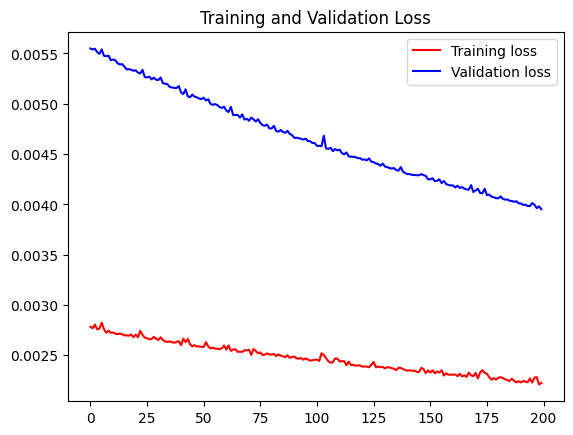

<Figure size 640x480 with 0 Axes>

In [43]:
loss = result.history["loss"]
val_loss = result.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.legend(loc=0)
plt.figure()

plt.show()

<h4>Avaliação do Modelo</h4>

In [44]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape, test_predict.shape

5/5 [==============================] - 0s 992us/step


((239, 1), (155, 1))

In [45]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(Y_train.reshape(-1, 1))
original_ytest = scaler.inverse_transform(Y_test.reshape(-1, 1))

<h4>Avaliação RMSE, MSE e MAE</h4>

In [48]:
print(f"Train data RMSE: {math.sqrt(mean_squared_error(original_ytrain, train_predict))}")
print(f"Train data MSE: {mean_squared_error(original_ytrain, train_predict)}")
print(f"Train date MAE: {mean_absolute_error(original_ytrain, train_predict)}")
print("=========================================================================================")
print(f"Test data RMSE: {math.sqrt(mean_squared_error(original_ytest, test_predict))}")
print(f"Test data MSE: {mean_squared_error(original_ytest, test_predict)}")
print(f"Test date MAE: {mean_absolute_error(original_ytest, test_predict)}")

Train data RMSE: 1812.2626018513872
Train data MSE: 3284295.7380691594
Train date MAE: 1402.5852317599372
Test data RMSE: 2424.458284323739
Test data MSE: 5877997.9724260075
Test date MAE: 1881.770554939516


<h4>Pontuação da vairiancia da Regreção</h4>

In [49]:
print(f"Pontuação da variancia para os dados de treino: {explained_variance_score(original_ytrain, train_predict)}")
print(f"Pontuação da variancia para os dados de test: {explained_variance_score(original_ytest, test_predict)}")

Pontuação da variancia para os dados de treino: 0.9616232289813889
Pontuação da variancia para os dados de test: 0.9371776779222759


<h4>Raiz quadrada de regressão</h4>

In [53]:
print(f"Pontuação R2 treino: {r2_score(original_ytrain, train_predict)}")
print(f"Pontuação R2 test: {r2_score(original_ytest, test_predict)}")

Pontuação R2 treino: 0.9616203283612552
Pontuação R2 test: 0.9371770477446882


<h2>Prevendo os proximos 30 dias</h2>

In [36]:
#Entrada inicial para o modelo
x_input = test_data[len(test_data) - time_stpe:].reshape(1, -1)

#converte para lista para podermos adicinar novos valores a medida que o loop avança
temp_imput = list(x_input)
temp_imput = temp_imput[0].tolist()

#Aramazena os valores preveistos
lst_output = []
n_steps = time_stpe 
i = 0
pred_days = 30

while(i < pred_days):
    if(len(temp_imput) > time_stpe):
        x_input = np.array(temp_imput[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_imput.extend(yhat[0].tolist())
        temp_imput = temp_imput[1:]
        
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_imput.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print(f"Output of predicted next days: {len(lst_output)}")
print(lst_output)

Output of predicted next days: 30
[[0.07984092086553574], [0.07784673571586609], [0.07625724375247955], [0.07561586797237396], [0.07624785602092743], [0.0780985951423645], [0.08105204999446869], [0.08457567542791367], [0.08828404545783997], [0.09188241511583328], [0.09526114910840988], [0.09842876344919205], [0.10169080644845963], [0.10462068766355515], [0.10735137015581131], [0.11003846675157547], [0.11286088079214096], [0.11562470346689224], [0.11831992119550705], [0.12094483524560928], [0.12350214272737503], [0.12599673867225647], [0.12843483686447144], [0.1308211386203766], [0.13315889239311218], [0.13544991612434387], [0.13769522309303284], [0.13989567756652832], [0.14205345511436462], [0.1441686451435089]]


<h2>Prevê o valor do Bitcoin para os proximos 30 dias</h2>

In [37]:
lstmdf = closed_date_df.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1, 1)).tolist())
#recupera os valores originais de preço,
lstmdf = scaler.inverse_transform(lstmdf).reshape(1, -1).tolist()[0]

historical_data = lstmdf[:-30]  
forecast_data = lstmdf[-30:]   

grap = px.line(labels={"value": "Stock", "index": "Timestamp"})
grap.add_scatter(x=list(range(len(historical_data))), y=historical_data, mode='lines', name='Dados Históricos', line=dict(color='blue'))
grap.add_scatter(x=list(range(len(historical_data), len(lstmdf))), y=forecast_data, mode='lines', name='Previsão (30 dias)', line=dict(color='orange'))
grap.update_layout(
    title_text="Gráfico com a previsão",
    plot_bgcolor="white",
    font_size=15,
    font_color="black",
    legend_title_text="Stock"
)
grap.update_xaxes(showgrid=False)
grap.update_yaxes(showgrid=False)
grap.show()